# objective

Design model to predict seed yield

In [2]:
#load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder  
from sklearn.preprocessing import StandardScaler  
from scipy import sparse
from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost as xgb
from math import sqrt
from sklearn.metrics import mean_squared_error
from scipy.stats import uniform, randint
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, RandomizedSearchCV
import random

/Users/edima/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
#load data
train = pd.read_csv('CC2020_train_final.csv')
test = pd.read_csv('CC2020_test_final.csv')

In [38]:
#set seed
np.random.seed(0)
seed = np.random.seed(0)

# Data Exploration

In [5]:
#check train
train.head()

YEAR  LOCATION      INBRED INBRED_CLUSTER      TESTER TESTER_CLUSTER  \
0    18  Loc 5608  Inbred_142      Cluster11  Tester_740      Cluster10   
1    18  Loc 4533  Inbred_142      Cluster11  Tester_740      Cluster10   
2    18  Loc 5620  Inbred_142      Cluster11  Tester_740      Cluster10   
3    18  Loc 4732  Inbred_142      Cluster11  Tester_740      Cluster10   
4    18  Loc 5500  Inbred_142      Cluster11  Tester_740      Cluster10   

      YIELD  
0  1.135462  
1  1.139813  
2  1.117778  
3  1.171366  
4  1.059364

In [6]:
#check test
test.head()

INBRED INBRED_CLUSTER       TESTER TESTER_CLUSTER  YIELD
0  Inbred_1071       Cluster8  Tester_5450       Cluster5    NaN
1   Inbred_122      Cluster12  Tester_4336       Cluster6    NaN
2  Inbred_1337      Cluster17  Tester_2652       Cluster1    NaN
3  Inbred_1337      Cluster17  Tester_4373       Cluster3    NaN
4  Inbred_1339      Cluster17  Tester_4238      Cluster11    NaN

In [7]:
#get train summary
train.describe()

YEAR          YIELD
count  199476.000000  199476.000000
mean       17.160551       1.001731
std         0.741779       0.104722
min        16.000000       0.047236
25%        17.000000       0.941870
50%        17.000000       1.003277
75%        18.000000       1.064073
max        18.000000       1.800083

In [8]:
#get test summary
test.describe()

YIELD
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN

In [9]:
#shapes
print("train shape")
print(train.shape)
print("test shape")
print(test.shape)

train shape
(199476, 7)
test shape
(1200, 5)


In [10]:
#check year column
train.YEAR.unique()

array([18, 17, 16])

In [11]:
#check location
train.LOCATION.unique()

array(['Loc 5608', 'Loc 4533', 'Loc 5620', 'Loc 4732', 'Loc 5500',
       'Loc 5514', 'Loc 4742', 'Loc 4625', 'Loc 4620', 'Loc 4524',
       'Loc 4442', 'Loc 4400', 'Loc 5420', 'Loc 4621', 'Loc 4601',
       'Loc 4532', 'Loc 4424', 'Loc 4341', 'Loc 4515', 'Loc 6609',
       'Loc 5424', 'Loc 5320', 'Loc 6415', 'Loc 4439', 'Loc 6730',
       'Loc 5330', 'Loc 5610', 'Loc 6700', 'Loc 6532', 'Loc 5711',
       'Loc 6634', 'Loc 6511', 'Loc 4623', 'Loc 4523', 'Loc 4Z23',
       'Loc 3631', 'Loc 3601', 'Loc 6418', 'Loc 6601', 'Loc 6614',
       'Loc 5511', 'Loc 4326', 'Loc 5324', 'Loc 4420', 'Loc 3437',
       'Loc 4401', 'Loc 3439', 'Loc 5336', 'Loc 7345', 'Loc 5340',
       'Loc 7319', 'Loc 6310', 'Loc 6421', 'Loc 7420', 'Loc 5240',
       'Loc 6320', 'Loc 8405', 'Loc 8316', 'Loc 7311', 'Loc 7612',
       'Loc 7332', 'Loc 7303', 'Loc 6734', 'Loc 7632', 'Loc 8320',
       'Loc 7243', 'Loc 8234', 'Loc 7440', 'Loc 7520', 'Loc 6334',
       'Loc 7727', 'Loc 7528', 'Loc 6719', 'Loc 7D06', 'Loc 73

In [12]:
#check INBRED
train.INBRED.unique()

array(['Inbred_142', 'Inbred_740', 'Inbred_743', 'Inbred_19',
       'Inbred_755', 'Inbred_737', 'Inbred_733', 'Inbred_739',
       'Inbred_754', 'Inbred_748', 'Inbred_750', 'Inbred_727',
       'Inbred_753', 'Inbred_586', 'Inbred_752', 'Inbred_736',
       'Inbred_749', 'Inbred_725', 'Inbred_761', 'Inbred_756',
       'Inbred_760', 'Inbred_757', 'Inbred_768', 'Inbred_765',
       'Inbred_764', 'Inbred_769', 'Inbred_759', 'Inbred_741',
       'Inbred_747', 'Inbred_745', 'Inbred_731', 'Inbred_773',
       'Inbred_738', 'Inbred_145', 'Inbred_777', 'Inbred_804',
       'Inbred_724', 'Inbred_122', 'Inbred_799', 'Inbred_803',
       'Inbred_732', 'Inbred_801', 'Inbred_800', 'Inbred_770',
       'Inbred_805', 'Inbred_751', 'Inbred_771', 'Inbred_744',
       'Inbred_790', 'Inbred_746', 'Inbred_1339', 'Inbred_789',
       'Inbred_1071', 'Inbred_1342', 'Inbred_1345', 'Inbred_1341',
       'Inbred_1346', 'Inbred_1340', 'Inbred_1349', 'Inbred_1360',
       'Inbred_1358', 'Inbred_1354', 'Inbred_13

In [13]:
#Inbred cluster
train.INBRED_CLUSTER.unique()

array(['Cluster11', 'Cluster10', 'Cluster12', 'Cluster8', 'Cluster17',
       'Cluster5', 'Cluster1', 'Cluster4', 'Cluster7', 'Cluster3',
       'Cluster14', 'Cluster6', 'Cluster9', 'Cluster2'], dtype=object)

In [14]:
#Tester information
train.TESTER.unique()

array(['Tester_740', 'Tester_743', 'Tester_757', 'Tester_761',
       'Tester_767', 'Tester_775', 'Tester_776', 'Tester_779',
       'Tester_789', 'Tester_793', 'Tester_813', 'Tester_819',
       'Tester_821', 'Tester_828', 'Tester_829', 'Tester_1345',
       'Tester_1349', 'Tester_1397', 'Tester_2636', 'Tester_2652',
       'Tester_2683', 'Tester_2689', 'Tester_2690', 'Tester_2721',
       'Tester_2724', 'Tester_2736', 'Tester_2747', 'Tester_2773',
       'Tester_3404', 'Tester_3440', 'Tester_3484', 'Tester_3485',
       'Tester_3504', 'Tester_3507', 'Tester_3521', 'Tester_3565',
       'Tester_3567', 'Tester_3573', 'Tester_3577', 'Tester_3582',
       'Tester_3791', 'Tester_3796', 'Tester_4025', 'Tester_4048',
       'Tester_4051', 'Tester_4059', 'Tester_4062', 'Tester_4063',
       'Tester_4065', 'Tester_4067', 'Tester_4072', 'Tester_4082',
       'Tester_4083', 'Tester_4097', 'Tester_4099', 'Tester_4102',
       'Tester_4115', 'Tester_4119', 'Tester_4131', 'Tester_4135',
       'Te

In [15]:
#TESTER_CLUSTER
train.TESTER_CLUSTER.unique()

array(['Cluster10', 'Cluster5', 'Cluster4', 'Cluster8', 'Cluster17',
       'Cluster11', 'Cluster1', 'Cluster3', 'Cluster7', 'Cluster12',
       'Cluster6', 'Cluster14', 'Cluster2'], dtype=object)

In [16]:
#Yield information
train.YIELD.unique()

array([1.13546205, 1.13981255, 1.1177782 , ..., 0.97258388, 0.90014022,
       0.95307504])

# Data visualization

[Text(0, 0, 'Cluster11'),
 Text(0, 0, 'Cluster10'),
 Text(0, 0, 'Cluster12'),
 Text(0, 0, 'Cluster8'),
 Text(0, 0, 'Cluster17'),
 Text(0, 0, 'Cluster5'),
 Text(0, 0, 'Cluster1'),
 Text(0, 0, 'Cluster4'),
 Text(0, 0, 'Cluster7'),
 Text(0, 0, 'Cluster3'),
 Text(0, 0, 'Cluster14'),
 Text(0, 0, 'Cluster6'),
 Text(0, 0, 'Cluster9'),
 Text(0, 0, 'Cluster2')]

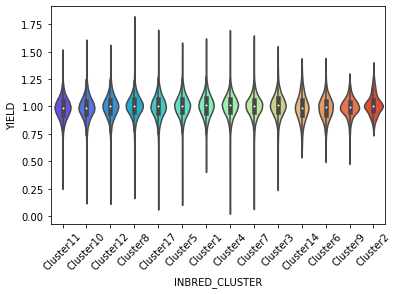

In [17]:
#inbred cluster and yield


#sns.violinplot(x="INBRED_CLUSTER", y="YIELD", data=train,palette='rainbow')

chart = sns.violinplot(x="INBRED_CLUSTER", y="YIELD", data=train,palette='rainbow')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

[Text(0, 0, 'Cluster10'),
 Text(0, 0, 'Cluster5'),
 Text(0, 0, 'Cluster4'),
 Text(0, 0, 'Cluster8'),
 Text(0, 0, 'Cluster17'),
 Text(0, 0, 'Cluster11'),
 Text(0, 0, 'Cluster1'),
 Text(0, 0, 'Cluster3'),
 Text(0, 0, 'Cluster7'),
 Text(0, 0, 'Cluster12'),
 Text(0, 0, 'Cluster6'),
 Text(0, 0, 'Cluster14'),
 Text(0, 0, 'Cluster2')]

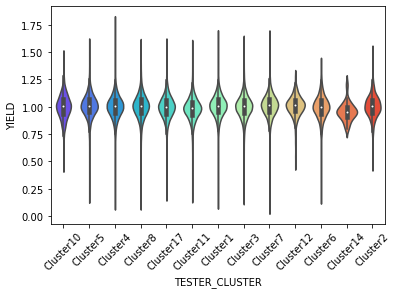

In [18]:
#tester cluster and yield
chart = sns.violinplot(x="TESTER_CLUSTER", y="YIELD", data=train,palette='rainbow')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

[Text(0, 0, 'Cluster10'),
 Text(0, 0, 'Cluster5'),
 Text(0, 0, 'Cluster4'),
 Text(0, 0, 'Cluster8'),
 Text(0, 0, 'Cluster17'),
 Text(0, 0, 'Cluster11'),
 Text(0, 0, 'Cluster1'),
 Text(0, 0, 'Cluster3'),
 Text(0, 0, 'Cluster7'),
 Text(0, 0, 'Cluster12'),
 Text(0, 0, 'Cluster6'),
 Text(0, 0, 'Cluster14'),
 Text(0, 0, 'Cluster2')]

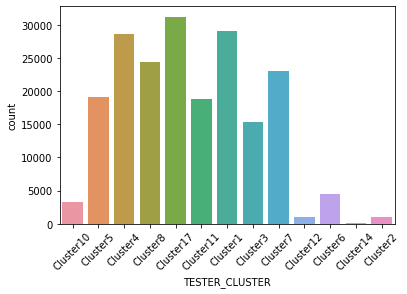

In [19]:
#count tester cluster
#frequency distribtion of TESTER CLUSTER
chart = sns.countplot(data = train, x = 'TESTER_CLUSTER')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

[Text(0, 0, 'Cluster11'),
 Text(0, 0, 'Cluster10'),
 Text(0, 0, 'Cluster12'),
 Text(0, 0, 'Cluster8'),
 Text(0, 0, 'Cluster17'),
 Text(0, 0, 'Cluster5'),
 Text(0, 0, 'Cluster1'),
 Text(0, 0, 'Cluster4'),
 Text(0, 0, 'Cluster7'),
 Text(0, 0, 'Cluster3'),
 Text(0, 0, 'Cluster14'),
 Text(0, 0, 'Cluster6'),
 Text(0, 0, 'Cluster9'),
 Text(0, 0, 'Cluster2')]

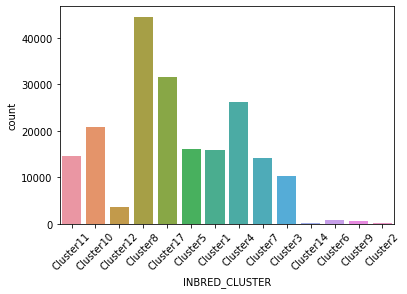

In [20]:
#count inbreed cluster
#frequency distribtion of inbred CLUSTER
#sns.countplot(data = train, x = 'INBRED_CLUSTER')
chart = sns.countplot(data = train, x = 'INBRED_CLUSTER')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

In [21]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [22]:
def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

In [23]:
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

In [24]:
#!pip install dython
import dython
from dython import nominal

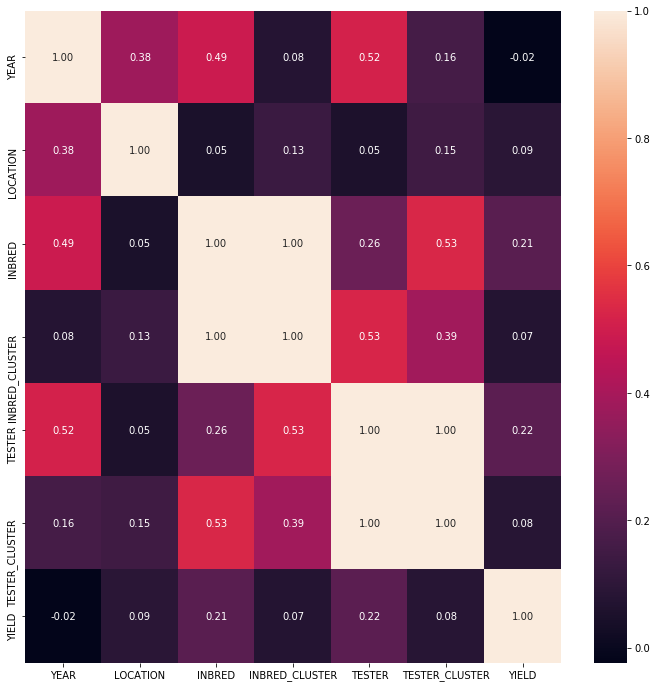

In [25]:
#correlation between cts and categorical variables
nominal.associations(train, correlation_ratio=True, 
                     nominal_columns=["LOCATION",'INBRED','INBRED_CLUSTER','TESTER','TESTER_CLUSTER'], 
                     figsize=(12,12))

# Data modeling

In [26]:
#check for missing data
train.isnull().sum()

YEAR              0
LOCATION          0
INBRED            0
INBRED_CLUSTER    0
TESTER            0
TESTER_CLUSTER    0
YIELD             0
dtype: int64

In [27]:
categorical = ["LOCATION",'INBRED','INBRED_CLUSTER','TESTER','TESTER_CLUSTER']

In [28]:
#hyper parameter tuning
#!pip install hyperopt

In [29]:
from hyperopt import hp
import numpy as np
from sklearn.metrics import mean_squared_error


# XGB parameters
xgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     100,
}
xgb_fit_params = {
    'eval_metric': 'rmse',
    'early_stopping_rounds': 10,
    'verbose': False
}
xgb_para = dict()
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))


# LightGBM parameters
lgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     100,
}
lgb_fit_params = {
    'eval_metric': 'l2',
    'early_stopping_rounds': 10,
    'verbose': False
}
lgb_para = dict()
lgb_para['reg_params'] = lgb_reg_params
lgb_para['fit_params'] = lgb_fit_params
lgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))


# CatBoost parameters
ctb_reg_params = {
    'learning_rate':     hp.choice('learning_rate',     np.arange(0.05, 0.31, 0.05)),
    'max_depth':         hp.choice('max_depth',         np.arange(5, 16, 1, dtype=int)),
    'colsample_bylevel': hp.choice('colsample_bylevel', np.arange(0.3, 0.8, 0.1)),
    'n_estimators':      100,
    'eval_metric':       'RMSE',
}
ctb_fit_params = {
    'early_stopping_rounds': 10,
    'verbose': False
}
ctb_para = dict()
ctb_para['reg_params'] = ctb_reg_params
ctb_para['fit_params'] = ctb_fit_params
ctb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

In [30]:
import lightgbm as lgb
import xgboost as xgb
import catboost as ctb
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials


class HPOpt(object):

    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train
        self.y_test  = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def xgb_reg(self, para):
        reg = xgb.XGBRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def lgb_reg(self, para):
        reg = lgb.LGBMRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def ctb_reg(self, para):
        reg = ctb.CatBoostRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, para):
        reg.fit(self.x_train, self.y_train,
                eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)],
                **para['fit_params'])
        pred = reg.predict(self.x_test)
        loss = para['loss_func'](self.y_test, pred)
        return {'loss': loss, 'status': STATUS_OK}

In [31]:
#obj = HPOpt(x_train, x_test, y_train, y_test)

#xgb_opt = obj.process(fn_name='xgb_reg', space=xgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)
#lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)
#ctb_opt = obj.process(fn_name='ctb_reg', space=ctb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)

In [32]:
#Create new training and test dataset
df_train = train[train['YEAR']<18]
df_test = train[train['YEAR']==18]

In [33]:
#drop the YEAR column in new train and test data
df_train_cat = df_train.drop(['YEAR'], axis=1)
df_test_cat = df_test.drop(['YEAR'], axis=1)

In [34]:
# Catboost model

# cat boost model 1

In [35]:
#split training data set
X_train1 = df_train_cat.drop(['YIELD'], axis=1)
y_train1 = df_train_cat.YIELD

#split test dataset
X_test1 = df_test_cat.drop(['YIELD'], axis=1)
y_test1 = df_test_cat.YIELD

def column_index(df, query_cols):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols, query_cols, sorter=sidx)]

categorical_features_indices = column_index(X_train1, categorical)
categorical_features_indices1 = column_index(X_test1, categorical)


model=CatBoostRegressor(iterations=500, depth=10, learning_rate=0.01, loss_function='RMSE')

In [36]:
model.fit(X_train1, y_train1,cat_features=categorical_features_indices,eval_set=(X_test1, y_test1),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.1013579	test: 0.1101568	best: 0.1101568 (0)	total: 354ms	remaining: 2m 56s
1:	learn: 0.1013005	test: 0.1101445	best: 0.1101445 (1)	total: 473ms	remaining: 1m 57s
2:	learn: 0.1012433	test: 0.1101323	best: 0.1101323 (2)	total: 696ms	remaining: 1m 55s
3:	learn: 0.1011651	test: 0.1101191	best: 0.1101191 (3)	total: 879ms	remaining: 1m 49s
4:	learn: 0.1010897	test: 0.1101098	best: 0.1101098 (4)	total: 1.04s	remaining: 1m 42s
5:	learn: 0.1010134	test: 0.1101003	best: 0.1101003 (5)	total: 1.22s	remaining: 1m 40s
6:	learn: 0.1009395	test: 0.1100918	best: 0.1100918 (6)	total: 1.55s	remaining: 1m 49s
7:	learn: 0.1008669	test: 0.1100827	best: 0.1100827 (7)	total: 1.81s	remaining: 1m 51s
8:	learn: 0.1007967	test: 0.1100721	best: 0.1100721 (8)	total: 1.97s	remaining: 1m 47s
9:	learn: 0.1007248	test: 0.1100631	best: 0.1100631 (9)	total: 2.14s	remaining: 1m 44s
10:	learn: 0.1006537	test: 0.1100548	best: 0.1100548 (10)	total: 2.26s	remaining: 1m 40s
11:	learn: 0.1005846	test: 0.1100476	best

94:	learn: 0.0970575	test: 0.1099229	best: 0.1098724 (59)	total: 13.4s	remaining: 57.2s
95:	learn: 0.0970309	test: 0.1099253	best: 0.1098724 (59)	total: 13.5s	remaining: 56.9s
96:	learn: 0.0970066	test: 0.1099301	best: 0.1098724 (59)	total: 13.6s	remaining: 56.5s
97:	learn: 0.0969832	test: 0.1099337	best: 0.1098724 (59)	total: 13.7s	remaining: 56.3s
98:	learn: 0.0969581	test: 0.1099377	best: 0.1098724 (59)	total: 13.8s	remaining: 56s
99:	learn: 0.0969341	test: 0.1099389	best: 0.1098724 (59)	total: 13.9s	remaining: 55.8s
100:	learn: 0.0969086	test: 0.1099404	best: 0.1098724 (59)	total: 14.1s	remaining: 55.5s
101:	learn: 0.0968844	test: 0.1099422	best: 0.1098724 (59)	total: 14.2s	remaining: 55.3s
102:	learn: 0.0968624	test: 0.1099454	best: 0.1098724 (59)	total: 14.3s	remaining: 55.3s
103:	learn: 0.0968393	test: 0.1099468	best: 0.1098724 (59)	total: 14.4s	remaining: 55s
104:	learn: 0.0968171	test: 0.1099513	best: 0.1098724 (59)	total: 14.6s	remaining: 54.7s
105:	learn: 0.0967943	test: 0.1

188:	learn: 0.0956353	test: 0.1102715	best: 0.1098724 (59)	total: 24.8s	remaining: 40.8s
189:	learn: 0.0956282	test: 0.1102772	best: 0.1098724 (59)	total: 24.9s	remaining: 40.7s
190:	learn: 0.0956189	test: 0.1102817	best: 0.1098724 (59)	total: 25s	remaining: 40.5s
191:	learn: 0.0956082	test: 0.1102869	best: 0.1098724 (59)	total: 25.1s	remaining: 40.3s
192:	learn: 0.0955980	test: 0.1102901	best: 0.1098724 (59)	total: 25.3s	remaining: 40.2s
193:	learn: 0.0955896	test: 0.1102950	best: 0.1098724 (59)	total: 25.4s	remaining: 40.1s
194:	learn: 0.0955821	test: 0.1103004	best: 0.1098724 (59)	total: 25.5s	remaining: 39.9s
195:	learn: 0.0955741	test: 0.1103046	best: 0.1098724 (59)	total: 25.6s	remaining: 39.8s
196:	learn: 0.0955649	test: 0.1103083	best: 0.1098724 (59)	total: 25.7s	remaining: 39.6s
197:	learn: 0.0955568	test: 0.1103105	best: 0.1098724 (59)	total: 25.8s	remaining: 39.4s
198:	learn: 0.0955498	test: 0.1103132	best: 0.1098724 (59)	total: 26s	remaining: 39.3s
199:	learn: 0.0955402	tes

282:	learn: 0.0950370	test: 0.1105659	best: 0.1098724 (59)	total: 36.1s	remaining: 27.7s
283:	learn: 0.0950321	test: 0.1105667	best: 0.1098724 (59)	total: 36.3s	remaining: 27.6s
284:	learn: 0.0950283	test: 0.1105691	best: 0.1098724 (59)	total: 36.4s	remaining: 27.4s
285:	learn: 0.0950241	test: 0.1105710	best: 0.1098724 (59)	total: 36.5s	remaining: 27.3s
286:	learn: 0.0950203	test: 0.1105716	best: 0.1098724 (59)	total: 36.7s	remaining: 27.2s
287:	learn: 0.0950183	test: 0.1105739	best: 0.1098724 (59)	total: 36.8s	remaining: 27.1s
288:	learn: 0.0950135	test: 0.1105762	best: 0.1098724 (59)	total: 36.9s	remaining: 26.9s
289:	learn: 0.0950097	test: 0.1105782	best: 0.1098724 (59)	total: 37s	remaining: 26.8s
290:	learn: 0.0950039	test: 0.1105798	best: 0.1098724 (59)	total: 37.1s	remaining: 26.7s
291:	learn: 0.0949989	test: 0.1105833	best: 0.1098724 (59)	total: 37.2s	remaining: 26.5s
292:	learn: 0.0949940	test: 0.1105867	best: 0.1098724 (59)	total: 37.4s	remaining: 26.4s
293:	learn: 0.0949902	t

375:	learn: 0.0946840	test: 0.1107564	best: 0.1098724 (59)	total: 47.7s	remaining: 15.7s
376:	learn: 0.0946803	test: 0.1107573	best: 0.1098724 (59)	total: 47.8s	remaining: 15.6s
377:	learn: 0.0946768	test: 0.1107590	best: 0.1098724 (59)	total: 48s	remaining: 15.5s
378:	learn: 0.0946734	test: 0.1107614	best: 0.1098724 (59)	total: 48.1s	remaining: 15.4s
379:	learn: 0.0946722	test: 0.1107624	best: 0.1098724 (59)	total: 48.2s	remaining: 15.2s
380:	learn: 0.0946700	test: 0.1107643	best: 0.1098724 (59)	total: 48.3s	remaining: 15.1s
381:	learn: 0.0946674	test: 0.1107658	best: 0.1098724 (59)	total: 48.4s	remaining: 15s
382:	learn: 0.0946650	test: 0.1107690	best: 0.1098724 (59)	total: 48.5s	remaining: 14.8s
383:	learn: 0.0946613	test: 0.1107712	best: 0.1098724 (59)	total: 48.7s	remaining: 14.7s
384:	learn: 0.0946597	test: 0.1107736	best: 0.1098724 (59)	total: 48.8s	remaining: 14.6s
385:	learn: 0.0946571	test: 0.1107755	best: 0.1098724 (59)	total: 48.9s	remaining: 14.4s
386:	learn: 0.0946543	tes

468:	learn: 0.0943978	test: 0.1108817	best: 0.1098724 (59)	total: 59.2s	remaining: 3.91s
469:	learn: 0.0943961	test: 0.1108832	best: 0.1098724 (59)	total: 59.4s	remaining: 3.79s
470:	learn: 0.0943933	test: 0.1108864	best: 0.1098724 (59)	total: 59.5s	remaining: 3.67s
471:	learn: 0.0943905	test: 0.1108880	best: 0.1098724 (59)	total: 59.6s	remaining: 3.54s
472:	learn: 0.0943879	test: 0.1108877	best: 0.1098724 (59)	total: 59.8s	remaining: 3.41s
473:	learn: 0.0943855	test: 0.1108894	best: 0.1098724 (59)	total: 59.9s	remaining: 3.29s
474:	learn: 0.0943825	test: 0.1108905	best: 0.1098724 (59)	total: 1m	remaining: 3.16s
475:	learn: 0.0943799	test: 0.1108912	best: 0.1098724 (59)	total: 1m	remaining: 3.03s
476:	learn: 0.0943750	test: 0.1108927	best: 0.1098724 (59)	total: 1m	remaining: 2.91s
477:	learn: 0.0943730	test: 0.1108928	best: 0.1098724 (59)	total: 1m	remaining: 2.78s
478:	learn: 0.0943699	test: 0.1108945	best: 0.1098724 (59)	total: 1m	remaining: 2.65s
479:	learn: 0.0943673	test: 0.110895

In [39]:
#Catboost parameter tuning
model =  CatBoostRegressor(iterations=700,
                             learning_rate=0.01,
                             depth=16,
                             eval_metric='RMSE',
                             random_seed = seed,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 75,
                             od_wait=100)
model.fit(X_train1, y_train1,
                 eval_set=(X_test1, y_test1),
                 cat_features=categorical_features_indices,
                 use_best_model=True)

0:	learn: 0.1013429	test: 0.1101540	best: 0.1101540 (0)	total: 2.67s	remaining: 31m 6s
75:	learn: 0.0958308	test: 0.1098614	best: 0.1098354 (57)	total: 2m 39s	remaining: 21m 48s
150:	learn: 0.0923452	test: 0.1101429	best: 0.1098354 (57)	total: 5m 37s	remaining: 20m 27s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1098353821
bestIteration = 57

Shrink model to first 58 iterations.


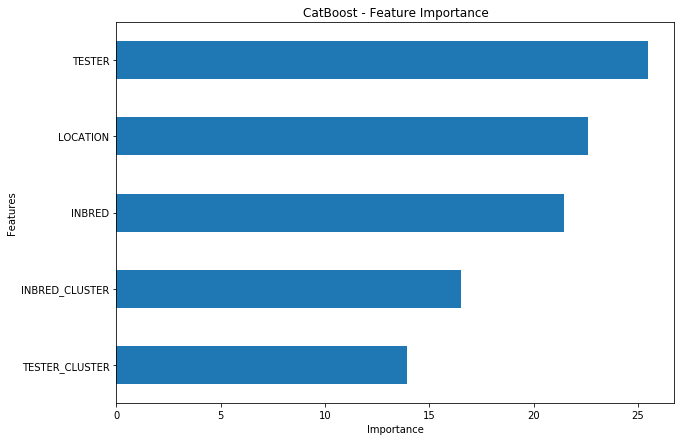

In [40]:
#Catboost feature importance
fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': X_train1.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance');

In [41]:
from sklearn.metrics import mean_squared_error
print("RMSE of the validation set:", np.sqrt(mean_squared_error(y_test1, model.predict(X_test1))))

RMSE of the validation set: 0.10983538217760232


In [42]:
#build test prediction
predicted_cat = model.predict(X_test1)

In [43]:
df_train

YEAR  LOCATION       INBRED INBRED_CLUSTER       TESTER  \
16        17  Loc 4533   Inbred_740      Cluster10   Tester_757   
17        17  Loc 4625   Inbred_740      Cluster10   Tester_757   
18        17  Loc 4524   Inbred_740      Cluster10   Tester_757   
19        17  Loc 5608   Inbred_740      Cluster10   Tester_757   
20        17  Loc 4442   Inbred_740      Cluster10   Tester_757   
21        17  Loc 4400   Inbred_740      Cluster10   Tester_757   
22        17  Loc 5420   Inbred_740      Cluster10   Tester_757   
23        17  Loc 4621   Inbred_740      Cluster10   Tester_757   
24        17  Loc 4620   Inbred_740      Cluster10   Tester_757   
25        17  Loc 4601   Inbred_740      Cluster10   Tester_757   
26        17  Loc 4732   Inbred_740      Cluster10   Tester_757   
27        17  Loc 4400   Inbred_743      Cluster10   Tester_761   
28        17  Loc 4621   Inbred_743      Cluster10   Tester_761   
29        17  Loc 4400    Inbred_19      Cluster10   Tester_761   
30        17  Loc 4532    Inbred_19      Cluster10   Tester_761   
31        17  Loc 4442    Inbred_19      Cluster10   Tester_761   
32        17  Loc 5420    Inbred_19      Cluster10   Tester_761   
33        17  Loc 5608   Inbred_743      Cluster10   Tester_761   
34        17  Loc 4442   Inbred_743      Cluster10   Tester_761   
35        17  Loc 4424    Inbred_19      Cluster10   Tester_761   
36        17  Loc 4533    Inbred_19      Cluster10   Tester_761   
37        17  Loc 4732   Inbred_743      Cluster10   Tester_761   
38        17  Loc 4341    Inbred_19      Cluster10   Tester_761   
39        17  Loc 4524   Inbred_743      Cluster10   Tester_761   
40        17  Loc 4515   Inbred_743      Cluster10   Tester_761   
41        17  Loc 4625    Inbred_19      Cluster10   Tester_761   
42        17  Loc 5420   Inbred_743      Cluster10   Tester_761   
43        17  Loc 4601   Inbred_743      Cluster10   Tester_761   
44        17  Loc 4625   Inbred_743      Cluster10   Tester_761   
45        17  Loc 4533   Inbred_743      Cluster10   Tester_761   
...      ...       ...          ...            ...          ...   
199233    17  Loc 6418  Inbred_5305       Cluster4  Tester_8253   
199234    17  Loc 6415  Inbred_5305       Cluster4  Tester_8253   
199236    17  Loc 7440  Inbred_5305       Cluster4  Tester_8253   
199240    17  Loc 6320  Inbred_5305       Cluster4  Tester_8253   
199247    17  Loc 7420  Inbred_5305       Cluster4  Tester_8253   
199248    17  Loc 6532  Inbred_4238      Cluster11  Tester_8253   
199252    17  Loc 7420  Inbred_4238      Cluster11  Tester_8253   
199254    17  Loc 6415  Inbred_4238      Cluster11  Tester_8253   
199259    17  Loc 7632  Inbred_4238      Cluster11  Tester_8253   
199260    17  Loc 6421  Inbred_4238      Cluster11  Tester_8253   
199267    17  Loc 7319  Inbred_4238      Cluster11  Tester_8253   
199269    17  Loc 7520  Inbred_4250      Cluster11  Tester_8253   
199278    17  Loc 7632  Inbred_4250      Cluster11  Tester_8253   
199279    17  Loc 7520  Inbred_4373       Cluster3  Tester_8253   
199280    17  Loc 7420  Inbred_4373       Cluster3  Tester_8253   
199285    17  Loc 6418  Inbred_4238      Cluster11  Tester_8253   
199286    17  Loc 6320  Inbred_4250      Cluster11  Tester_8253   
199290    17  Loc 6418  Inbred_4373       Cluster3  Tester_8253   
199292    17  Loc 6320  Inbred_4238      Cluster11  Tester_8253   
199293    17  Loc 6421  Inbred_4250      Cluster11  Tester_8253   
199297    17  Loc 6320  Inbred_4373       Cluster3  Tester_8253   
199299    17  Loc 7632  Inbred_4373       Cluster3  Tester_8253   
199314    17  Loc 7440  Inbred_4238      Cluster11  Tester_8253   
199322    17  Loc 7319  Inbred_4373       Cluster3  Tester_8253   
199323    17  Loc 7319  Inbred_4250      Cluster11  Tester_8253   
199330    17  Loc 7520  Inbred_5305       Cluster4  Tester_8253   
199332    17  Loc 7632  Inbred_5305       Cluster4  Tester_8253   
199333    17  Loc 6418  Inbred_4250      Cluster11  Tes

In [44]:
#more parameter tuning
#obj = HPOpt(X_train1, X_test1, y_train1, y_test1)
#ctb_opt = obj.process(fn_name='ctb_reg', space=ctb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)

# Light GBM Model 1

In [45]:
train = pd.read_csv('CC2020_train_final.csv')
test = pd.read_csv('CC2020_test_final.csv')

In [55]:
#Create new training and test dataset
df_train = train[train['YEAR']<18]
df_test = train[train['YEAR']==18]

In [56]:
#drop the YEAR, LOCATION column in new train and test data
df_train1 = df_train.drop(['YEAR','LOCATION'], axis=1)
df_test1 = df_test.drop(['YEAR','LOCATION'], axis=1)

In [57]:
#drop the YEAR, LOCATION column in new train and test data
#df_train = df_train.drop(['YEAR','LOCATION'], axis=1)
#df_test = df_test.drop(['YEAR','LOCATION'], axis=1)

In [58]:
categorical = ['INBRED','INBRED_CLUSTER','TESTER','TESTER_CLUSTER']
label_encoder = preprocessing.LabelEncoder()
for col in categorical:
    df_train1[col] = label_encoder.fit_transform(df_train1[col].astype(str))
    df_test1[col] = label_encoder.fit_transform(df_test1[col].astype(str))


In [59]:
#split training data set
X_train2 = df_train1.drop(['YIELD'], axis=1)
y_train2 = df_train1.YIELD

#split test dataset
X_test2 = df_test1.drop(['YIELD'], axis=1)
y_test2 = df_test1.YIELD

In [63]:
X = df_train1.loc[:, df_train1.columns != 'YIELD']
feature_names = X.columns.tolist()

In [64]:
# LightGBM dataset formatting 
lgtrain = lgb.Dataset(X_train2, y_train2,
                feature_name=feature_names,
                categorical_feature = categorical)
lgvalid = lgb.Dataset(X_test2, y_test2,
                feature_name=feature_names,
                categorical_feature = categorical)

In [65]:
params = {
    'objective' : 'regression',
    'metric' : 'rmse',
    'num_leaves' : 200,
    'max_depth': 15,
    'learning_rate' : 0.01,
    'feature_fraction' : 0.6,
    'verbosity' : -1
}

lgb_clf = lgb.train(
    params,
    lgtrain,
    20000,
    valid_sets=[lgtrain, lgvalid],
    valid_names=['train', 'test'],
    early_stopping_rounds=500,
    verbose_eval=500
)

Training until validation scores don't improve for 500 rounds
[500]	train's rmse: 0.0964248	test's rmse: 0.115267
Early stopping, best iteration is:
[19]	train's rmse: 0.100491	test's rmse: 0.110106


In [66]:
from sklearn.metrics import mean_squared_error
print("RMSE of the validation set:", np.sqrt(mean_squared_error(y_test2, lgb_clf.predict(X_test2))))

RMSE of the validation set: 0.11010635056202028


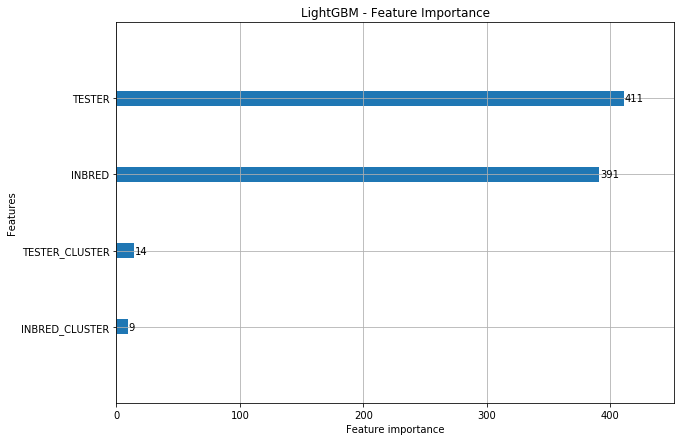

In [67]:
#feature importance
fig, ax = plt.subplots(figsize=(10, 7))
lgb.plot_importance(lgb_clf, max_num_features=30, ax=ax)
plt.title("LightGBM - Feature Importance");

In [68]:
# test prediction
prediction_light = lgb_clf.predict(X_test2)

In [69]:
#obj = HPOpt(X_train2, X_test2, y_train2, y_test2)
#lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)

# XGBoost Model

In [70]:
train = pd.read_csv('CC2020_train_final.csv')
test = pd.read_csv('CC2020_test_final.csv')

In [71]:
#Create new training and test dataset
df_train = train[train['YEAR']<18]
df_test = train[train['YEAR']==18]

In [72]:
#drop the YEAR, LOCATION column in new train and test data
df_train2 = df_train.drop(['YEAR','LOCATION'], axis=1)
df_test2 = df_test.drop(['YEAR','LOCATION'], axis=1)

In [73]:
import xgboost as xgb
target_encode_columns = ['INBRED','TESTER','TESTER_CLUSTER','INBRED_CLUSTER']
target = ['YIELD']
target_encode_df = df_train2[target_encode_columns + target].reset_index().drop(columns = 'index', axis = 1)
target_name = target[0]
target_df = pd.DataFrame()
for embed_col in target_encode_columns:
    val_map = target_encode_df.groupby(embed_col)[target].mean().to_dict()[target_name]
    target_df[embed_col] = target_encode_df[embed_col].map(val_map).values
    
score_target_drop = df_train2.drop(target_encode_columns, axis = 1).reset_index().drop(columns = 'index', axis = 1)
score_target = pd.concat([score_target_drop, target_df], axis = 1)

In [74]:
score_target.head()

YIELD    INBRED    TESTER  TESTER_CLUSTER  INBRED_CLUSTER
0  0.914693  1.014345  0.974859        1.001545        0.990321
1  0.947855  1.014345  0.974859        1.001545        0.990321
2  0.938258  1.014345  0.974859        1.001545        0.990321
3  1.037171  1.014345  0.974859        1.001545        0.990321
4  0.898236  1.014345  0.974859        1.001545        0.990321

In [75]:
target_encode_columns = ['INBRED','TESTER','TESTER_CLUSTER','INBRED_CLUSTER']
target = ['YIELD']
target_encode_df = df_test2[target_encode_columns + target].reset_index().drop(columns = 'index', axis = 1)
target_name = target[0]
target_df = pd.DataFrame()
for embed_col in target_encode_columns:
    val_map = target_encode_df.groupby(embed_col)[target].mean().to_dict()[target_name]
    target_df[embed_col] = target_encode_df[embed_col].map(val_map).values
    
score_target_drop = df_test2.drop(target_encode_columns, axis = 1).reset_index().drop(columns = 'index', axis = 1)
score_test = pd.concat([score_target_drop, target_df], axis = 1)

In [76]:
#split training data set
X_train3 = score_target.drop(['YIELD'], axis=1)
y_train3 = score_target.YIELD

#split test dataset
X_test3 = score_test.drop(['YIELD'], axis=1)
y_test3 = score_test.YIELD

In [77]:
params = {'colsample_bytree': uniform(0.7, 0.3),
          'gamma': uniform(0, 0.5),
          'learning_rate': uniform(0.003, 0.3), # default 0.1 
          'max_depth': randint(2, 6), # default 3
          'n_estimators': randint(100, 250), # default 100
          'subsample': uniform(0.6, 0.4)}
xgb_model = xgb.XGBRegressor(objective="reg:squarederror",random_state=42)
time_split = TimeSeriesSplit(n_splits = 8)
xgb_search = RandomizedSearchCV(xgb_model,param_distributions=params, 
                                random_state=42, n_iter=4, cv=time_split, 
                                verbose=1, n_jobs=1, return_train_score=True)

In [78]:
xgb_search.fit(X_train3, y_train3)

Fitting 8 folds for each of 4 candidates, totalling 32 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:  2.7min finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=8),
                   error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a2ac87ef0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a25881f28>,
      

In [79]:
predicted_xgb = xgb_search.predict(X_test3)
rms = sqrt(mean_squared_error(y_test3, predicted_xgb ))
print ('RMSE:', rms)

RMSE: 0.104248887562759


In [ ]:
#feature importance
#import matplotlib.pyplot as plt
#xgb.plot_tree(xg_reg,num_trees=0)
#plt.rcParams['figure.figsize'] = [50, 10]
#plt.show()

In [ ]:
# Parameter tuning

In [ ]:
#obj = HPOpt(X_train3, X_test3, y_train3, y_test3)
#xgb_opt = obj.process(fn_name='xgb_reg', space=xgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)

# Ensemble Model

In [86]:
ensemble_preds_65_30_05 = 0.65 * prediction_light + 0.30 * predicted_cat + 0.05 * predicted_xgb 
ensemble_preds_70_25_05 = 0.70 * prediction_light + 0.25 * predicted_cat + 0.05 * predicted_xgb 
ensemble_preds_75_20_05 = 0.75 * prediction_light + 0.20 * predicted_cat + 0.05 * predicted_xgb 
ensemble_preds_80_15_05 = 0.80 * prediction_light + 0.20 * predicted_cat + 0.05 * predicted_xgb 
ensemble_preds_85_10_05 = 0.85 * prediction_light + 0.10 * predicted_cat + 0.05 * predicted_xgb 
ensemble_preds_90_05_05 = 0.90 * prediction_light + 0.05 * predicted_cat + 0.05 * predicted_xgb 

ensemble_preds_10_40_50 = 0.10 * prediction_light + 0.40 * predicted_cat + 0.50 * predicted_xgb 
ensemble_preds_10_30_60 = 0.10 * prediction_light + 0.30 * predicted_cat + 0.60 * predicted_xgb

ensemble_preds_25_25_50 = 0.25 * prediction_light + 0.25 * predicted_cat + 0.50 * predicted_xgb 
ensemble_preds_20_20_60 = 0.20 * prediction_light + 0.20 * predicted_cat + 0.60 * predicted_xgb 
ensemble_preds_15_15_70 = 0.15 * prediction_light + 0.15 * predicted_cat + 0.70 * predicted_xgb 
ensemble_preds_10_10_80 = 0.1 * prediction_light + 0.1 * predicted_cat + 0.80 * predicted_xgb 
ensemble_preds_05_05_90 = 0.05 * prediction_light + 0.05 * predicted_cat + 0.90 * predicted_xgb

ensemble_preds_00_50_50 = 0.00 * prediction_light + 0.50 * predicted_cat + 0.50 * predicted_xgb
ensemble_preds_00_40_60 = 0.00 * prediction_light + 0.40 * predicted_cat + 0.60 * predicted_xgb
ensemble_preds_00_30_70 = 0.00 * prediction_light + 0.30 * predicted_cat + 0.70 * predicted_xgb 
ensemble_preds_00_20_80 = 0.0 * prediction_light + 0.20 * predicted_cat + 0.80 * predicted_xgb 
ensemble_preds_00_10_90 = 0.00 * prediction_light + 0.10 * predicted_cat + 0.90 * predicted_xgb 


In [89]:
#convert to pandas dataframe
ensemble_preds_65_30_05_df = pd.Series(ensemble_preds_65_30_05)
ensemble_preds_70_25_05_df = pd.Series(ensemble_preds_70_25_05)
ensemble_preds_75_20_05_df = pd.Series(ensemble_preds_75_20_05)
ensemble_preds_80_15_05_df = pd.Series(ensemble_preds_80_15_05)
ensemble_preds_85_10_05_df = pd.Series(ensemble_preds_85_10_05)
ensemble_preds_90_05_05_df = pd.Series(ensemble_preds_90_05_05)

ensemble_preds_10_40_50_df = pd.Series(ensemble_preds_10_40_50)
ensemble_preds_10_30_60_df = pd.Series(ensemble_preds_10_30_60)

ensemble_preds_25_25_50_df = pd.Series(ensemble_preds_25_25_50)
ensemble_preds_20_20_60_df = pd.Series(ensemble_preds_20_20_60)
ensemble_preds_15_15_70_df = pd.Series(ensemble_preds_15_15_70)
ensemble_preds_10_10_80_df = pd.Series(ensemble_preds_10_10_80)
ensemble_preds_05_05_90_df = pd.Series(ensemble_preds_05_05_90)

ensemble_preds_00_50_50_df = pd.Series(ensemble_preds_00_50_50)
ensemble_preds_00_40_60_df = pd.Series(ensemble_preds_00_40_60)
ensemble_preds_00_30_70_df = pd.Series(ensemble_preds_00_30_70)
ensemble_preds_00_20_80_df = pd.Series(ensemble_preds_00_20_80)
ensemble_preds_00_10_90_df = pd.Series(ensemble_preds_00_10_90)

In [90]:
ensemble_preds_00_10_90_df.head()

0    1.058544
1    1.058262
2    1.058517
3    1.057914
4    1.058662
dtype: float64

In [93]:
ensemble_preds_65_30_05_df.head()

0    1.010709
1    1.009860
2    1.010628
3    1.008819
4    1.011060
dtype: float64

In [92]:
ensemble_preds_90_05_05_df.head()

0    1.011647
1    1.011506
2    1.011634
3    1.011332
4    1.011706
dtype: float64

In [81]:
#generate outputs
df_test.reset_index(drop=True, inplace=True)
predict_xgb = pd.Series(predicted_xgb)
predict_cat = pd.Series(predicted_cat)
predict_light = pd.Series(prediction_light)
#predicted_xgb.reset_index(drop=True, inplace=True)
#prediction_light.reset_index(drop=True, inplace=True)
#predicted_cat.reset_index(drop=True, inplace=True)

In [82]:
#xgboost
submission = pd.concat([df_test, predict_xgb], axis=1)
submission.head()
submission.to_csv("submission_xgbm.csv",index=False)

In [83]:
#catboost
submission = pd.concat([df_test, predict_cat], axis=1)
submission.head()
submission.to_csv("submission_cat.csv",index=False)

In [84]:
#lgbm
submission = pd.concat([df_test, predict_light], axis=1)
submission.head()
submission.to_csv("submission_light.csv",index=False)

In [96]:
#ensemble
submission = pd.concat([df_test, ensemble_preds_65_30_05_df], axis=1)
submission.head()
submission.to_csv("submission_ensemble.csv",index=False)